In [36]:
# ================================================================
# CELL 1: Mount Google Drive and Setup
# ================================================================

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set your data path in Google Drive
# Update this path to where your data folder is located
DRIVE_DATA_PATH = '/content/drive/MyDrive/data'  # Change this to your path

# Verify the path exists
if os.path.exists(DRIVE_DATA_PATH):
    print(f"✅ Data folder found at: {DRIVE_DATA_PATH}")
else:
    print(f"❌ Data folder NOT found at: {DRIVE_DATA_PATH}")
    print("Please update DRIVE_DATA_PATH to your correct Google Drive path")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data folder found at: /content/drive/MyDrive/data


In [37]:
# ================================================================
# CELL 2: Install Dependencies
# ================================================================

!pip install ultralytics pyzbar opencv-python PyYAML tqdm matplotlib scipy -q

# Install system dependencies for pyzbar
!apt-get update -qq
!apt-get install -y libzbar0 -qq

print("✅ All dependencies installed!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ All dependencies installed!


In [38]:
# ================================================================
# CELL 3: Verify GPU and Setup
# ================================================================

import torch
import sys

print("=" * 70)
print("Environment Check")
print("=" * 70)

# Check Python version
print(f"\n🐍 Python: {sys.version.split()[0]}")

# Check PyTorch and CUDA
print(f"\n🔥 PyTorch: {torch.__version__}")
print(f"🎮 CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA Version: {torch.version.cuda}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("   ⚠️ No GPU detected! Check Runtime > Change runtime type > GPU")

# Check Ultralytics
from ultralytics import YOLO
print(f"\n✅ Ultralytics installed successfully")

print("=" * 70)

Environment Check

🐍 Python: 3.12.11

🔥 PyTorch: 2.8.0+cu126
🎮 CUDA Available: True
   GPU: Tesla T4
   CUDA Version: 12.6
   GPU Memory: 15.83 GB

✅ Ultralytics installed successfully


In [39]:
# ================================================================
# CELL 4: Create Project Structure
# ================================================================

import os

# Create directory structure
directories = [
    'src',
    'src/utils',
    'outputs',
    'outputs/qr_detection',
    'outputs/qr_detection/weights'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

print("✅ Project structure created!")
print("\nDirectory structure:")
for directory in directories:
    print(f"  📁 {directory}")

✅ Project structure created!

Directory structure:
  📁 src
  📁 src/utils
  📁 outputs
  📁 outputs/qr_detection
  📁 outputs/qr_detection/weights


In [40]:
# ================================================================
# CELL 5: Create src/__init__.py
# ================================================================

%%writefile src/__init__.py
"""
Multi-QR Code Detection - Source Package
"""

__version__ = "1.0.0"
__author__ = "Hackathon Participant"
__description__ = "Multi-QR Code Recognition for Medicine Packs"

Overwriting src/__init__.py


In [41]:
# ================================================================
# CELL 7: Create src/utils/qr_decoder.py
# ================================================================

%%writefile src/utils/qr_decoder.py
"""
QR Code Decoder and Classifier
Decodes QR codes and classifies them by type
"""

import cv2
import numpy as np
from pyzbar import pyzbar
import re

def preprocess_qr_region(image):
    """
    Preprocess QR code region for better decoding

    Args:
        image: QR code region (BGR)

    Returns:
        list: Preprocessed image variants
    """
    variants = []

    # Original
    variants.append(image.copy())

    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variants.append(gray)

    # Binary threshold (Otsu)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    variants.append(binary)

    # Adaptive threshold
    adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    variants.append(adaptive)

    # Sharpen
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(gray, -1, kernel)
    variants.append(sharpened)

    # Denoise + threshold
    denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
    _, denoised_binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    variants.append(denoised_binary)

    # Morphological operations
    kernel_morph = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_morph)
    variants.append(morph)

    return variants

def classify_qr_type(decoded_text):
    """
    Classify QR code based on decoded content

    Args:
        decoded_text: Decoded QR string

    Returns:
        str: QR type classification
    """
    if not decoded_text:
        return "unknown"

    text_upper = decoded_text.upper()

    # Batch number patterns
    batch_patterns = [
        r'\bBATCH\b', r'\bLOT\b', r'\bB\d+\b', r'\bLOT\d+\b',
        r'\bBN\d+\b', r'\bBATCH\s*[:#]?\s*[A-Z0-9]+\b'
    ]
    for pattern in batch_patterns:
        if re.search(pattern, text_upper):
            return "batch_number"

    # Manufacturer patterns
    mfr_patterns = [
        r'\bMFR\b', r'\bMFG\b', r'\bMANUFACTURER\b', r'\bMADE\s+BY\b',
        r'\bCOMPANY\b', r'\bPRODUCED\s+BY\b'
    ]
    for pattern in mfr_patterns:
        if re.search(pattern, text_upper):
            return "manufacturer"

    # Distributor patterns
    dist_patterns = [
        r'\bDIST\b', r'\bDISTRIBUTOR\b', r'\bDISTRIBUTED\s+BY\b',
        r'\bWHOLESALER\b', r'\bSUPPLIER\b'
    ]
    for pattern in dist_patterns:
        if re.search(pattern, text_upper):
            return "distributor"

    # Regulatory patterns
    reg_patterns = [
        r'\bFDA\b', r'\bCE\b', r'\bISO\b', r'\bREG\b',
        r'\bAPPROVED\b', r'\bCERTIFIED\b', r'\bLICENSE\b',
        r'\bREGISTRATION\b'
    ]
    for pattern in reg_patterns:
        if re.search(pattern, text_upper):
            return "regulatory"

    # Product code patterns
    product_patterns = [
        r'\bPROD\b', r'\bSKU\b', r'\bITEM\b', r'\bCODE\b',
        r'\bP\d+\b', r'\bPRODUCT\s+CODE\b'
    ]
    for pattern in product_patterns:
        if re.search(pattern, text_upper):
            return "product_code"

    # URL patterns
    if re.search(r'https?://', decoded_text, re.IGNORECASE):
        return "url"

    # Serial number patterns
    if re.search(r'\bSERIAL\b|\bSN\b|\bS/N\b', text_upper):
        return "serial_number"

    # Expiry date patterns
    if re.search(r'\bEXP\b|\bEXPIRY\b|\bEXPIRES\b|\bUSE\s+BY\b', text_upper):
        return "expiry_date"

    # Default classification based on content type
    if re.match(r'^[A-Z0-9]{6,}$', decoded_text):
        return "alphanumeric_code"
    elif re.match(r'^\d+$', decoded_text):
        return "numeric_code"

    return "general"

def decode_qr_codes(qr_region):
    """
    Decode QR code from image region with multiple preprocessing attempts

    Args:
        qr_region: Image region containing QR code (BGR or grayscale)

    Returns:
        tuple: (decoded_text, qr_type) or (None, None) if decoding fails
    """
    if qr_region is None or qr_region.size == 0:
        return None, None

    # Preprocess image
    variants = preprocess_qr_region(qr_region)

    # Try decoding with each variant
    for variant in variants:
        try:
            decoded_objects = pyzbar.decode(variant)

            if decoded_objects:
                # Get the first decoded QR code
                qr = decoded_objects[0]
                decoded_text = qr.data.decode('utf-8', errors='ignore')

                # Classify QR type
                qr_type = classify_qr_type(decoded_text)

                return decoded_text, qr_type
        except Exception as e:
            continue

    # Try with rotations if initial attempts fail
    for angle in [90, 180, 270]:
        try:
            rotated = cv2.rotate(qr_region,
                               cv2.ROTATE_90_CLOCKWISE if angle == 90
                               else cv2.ROTATE_180 if angle == 180
                               else cv2.ROTATE_90_COUNTERCLOCKWISE)

            decoded_objects = pyzbar.decode(rotated)
            if decoded_objects:
                qr = decoded_objects[0]
                decoded_text = qr.data.decode('utf-8', errors='ignore')
                qr_type = classify_qr_type(decoded_text)
                return decoded_text, qr_type
        except Exception as e:
            continue

    # Decoding failed
    return None, None

def decode_qr_batch(image_path, bboxes):
    """
    Decode multiple QR codes from an image given bounding boxes

    Args:
        image_path: Path to image
        bboxes: List of bounding boxes [[x_min, y_min, x_max, y_max], ...]

    Returns:
        list: [(decoded_text, qr_type), ...] for each bbox
    """
    image = cv2.imread(image_path)
    if image is None:
        return [(None, None)] * len(bboxes)

    results = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox

        # Add padding
        padding = 10
        y1 = max(0, y_min - padding)
        y2 = min(image.shape[0], y_max + padding)
        x1 = max(0, x_min - padding)
        x2 = min(image.shape[1], x_max + padding)

        qr_region = image[y1:y2, x1:x2]
        decoded_text, qr_type = decode_qr_codes(qr_region)
        results.append((decoded_text, qr_type))

    return results

Overwriting src/utils/qr_decoder.py


In [42]:
# ================================================================
# CELL 8: Create src/utils/nms_utils.py
# ================================================================

%%writefile src/utils/nms_utils.py
"""
Non-Maximum Suppression (NMS) Utilities
Custom NMS implementation for handling overlapping QR code detections
"""

import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two boxes

    Args:
        box1, box2: [x_min, y_min, x_max, y_max]

    Returns:
        float: IoU value
    """
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_max < inter_x_min or inter_y_max < inter_y_min:
        return 0.0

    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)

    # Calculate union
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0.0

def calculate_box_area(box):
    """Calculate area of a bounding box"""
    x_min, y_min, x_max, y_max = box
    return (x_max - x_min) * (y_max - y_min)

def apply_custom_nms(bboxes, iou_threshold=0.45):
    """
    Apply custom Non-Maximum Suppression to remove overlapping detections

    For medicine packs, we want to keep all distinct QR codes while removing
    duplicates from the same QR code detected multiple times.

    Args:
        bboxes: List of bounding boxes [[x_min, y_min, x_max, y_max], ...]
        iou_threshold: IoU threshold for suppression

    Returns:
        list: Filtered bounding boxes
    """
    if len(bboxes) == 0:
        return []

    # Convert to numpy array
    boxes = np.array(bboxes, dtype=np.float32)

    # Calculate areas
    areas = np.array([calculate_box_area(box) for box in boxes])

    # Sort by area (larger boxes first - they're more likely to be complete QR codes)
    order = areas.argsort()[::-1]

    keep = []

    while len(order) > 0:
        # Pick the box with largest area
        i = order[0]
        keep.append(i)

        if len(order) == 1:
            break

        # Calculate IoU with remaining boxes
        ious = np.array([calculate_iou(boxes[i], boxes[j]) for j in order[1:]])

        # Keep boxes with IoU less than threshold
        remaining = np.where(ious < iou_threshold)[0]
        order = order[remaining + 1]

    return [bboxes[i] for i in keep]

def merge_close_boxes(bboxes, distance_threshold=20):
    """
    Merge bounding boxes that are very close to each other
    Useful for handling fragmented detections of the same QR code

    Args:
        bboxes: List of bounding boxes
        distance_threshold: Maximum distance between box centers to merge

    Returns:
        list: Merged bounding boxes
    """
    if len(bboxes) <= 1:
        return bboxes

    def get_center(box):
        x_min, y_min, x_max, y_max = box
        return ((x_min + x_max) / 2, (y_min + y_max) / 2)

    def distance(center1, center2):
        return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

    def merge_two_boxes(box1, box2):
        x_min = min(box1[0], box2[0])
        y_min = min(box1[1], box2[1])
        x_max = max(box1[2], box2[2])
        y_max = max(box1[3], box2[3])
        return [x_min, y_min, x_max, y_max]

    merged = []
    used = set()

    for i in range(len(bboxes)):
        if i in used:
            continue

        current_box = bboxes[i]
        current_center = get_center(current_box)

        # Find boxes to merge with current box
        to_merge = [current_box]
        used.add(i)

        for j in range(i + 1, len(bboxes)):
            if j in used:
                continue

            other_center = get_center(bboxes[j])
            if distance(current_center, other_center) < distance_threshold:
                to_merge.append(bboxes[j])
                used.add(j)

        # Merge all close boxes
        if len(to_merge) == 1:
            merged.append(current_box)
        else:
            merged_box = to_merge[0]
            for box in to_merge[1:]:
                merged_box = merge_two_boxes(merged_box, box)
            merged.append(merged_box)

    return merged

Overwriting src/utils/nms_utils.py


In [43]:
# ================================================================
# CELL 9: Create src/utils/data_utils.py (Part 1)
# ================================================================

%%writefile src/utils/data_utils.py
"""
Data Utilities
Helper functions for data processing and visualization
"""

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_detections(image_path, bboxes, output_path=None, show=False):
    """
    Visualize QR code detections on image

    Args:
        image_path: Path to input image
        bboxes: List of bounding boxes [[x_min, y_min, x_max, y_max], ...]
        output_path: Path to save visualization (optional)
        show: Whether to display image
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return

    # Draw bounding boxes
    for i, bbox in enumerate(bboxes):
        x_min, y_min, x_max, y_max = map(int, bbox)

        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

        # Add label
        label = f"QR {i+1}"
        cv2.putText(image, label, (x_min, y_min - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Save if output path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, image)
        print(f"Visualization saved to {output_path}")

    # Display if requested
    if show:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"QR Detections: {len(bboxes)} codes found")
        plt.tight_layout()
        plt.show()

def visualize_detections_with_labels(image_path, detections, output_path=None, show=False):
    """
    Visualize QR code detections with decoded values

    Args:
        image_path: Path to input image
        detections: List of dicts with 'bbox', 'value', 'type'
        output_path: Path to save visualization
        show: Whether to display image
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return

    # Draw bounding boxes with labels
    for i, det in enumerate(detections):
        bbox = det['bbox']
        value = det.get('value', 'N/A')
        qr_type = det.get('type', 'unknown')

        x_min, y_min, x_max, y_max = map(int, bbox)

        # Color based on decode success
        color = (0, 255, 0) if value != 'DECODE_FAILED' else (0, 165, 255)

        # Draw rectangle
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

        # Add labels
        label1 = f"QR {i+1}: {qr_type}"
        label2 = f"{value[:20]}..." if len(value) > 20 else value

        # Background for text
        (w1, h1), _ = cv2.getTextSize(label1, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        (w2, h2), _ = cv2.getTextSize(label2, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)

        cv2.rectangle(image, (x_min, y_min - h1 - h2 - 20),
                     (x_min + max(w1, w2) + 10, y_min), (0, 0, 0), -1)

        cv2.putText(image, label1, (x_min + 5, y_min - h2 - 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        cv2.putText(image, label2, (x_min + 5, y_min - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

    # Save if output path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, image)
        print(f"Visualization saved to {output_path}")

    # Display if requested
    if show:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"QR Detections: {len(detections)} codes found")
        plt.tight_layout()
        plt.show()

def load_yolo_annotations(label_path, img_width, img_height):
    """
    Load YOLO format annotations and convert to bounding boxes

    Args:
        label_path: Path to YOLO .txt file
        img_width: Image width
        img_height: Image height

    Returns:
        list: Bounding boxes [[x_min, y_min, x_max, y_max], ...]
    """
    if not os.path.exists(label_path):
        return []

    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split()
                # class_id x_center y_center width height (normalized)
                x_center = float(parts[1]) * img_width
                y_center = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height

                x_min = int(x_center - width / 2)
                y_min = int(y_center - height / 2)
                x_max = int(x_center + width / 2)
                y_max = int(y_center + height / 2)

                bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes

def create_dataset_summary(dataset_path):
    """
    Create a summary of the dataset

    Args:
        dataset_path: Path to dataset directory
    """
    train_images = os.path.join(dataset_path, 'train', 'images')
    train_labels = os.path.join(dataset_path, 'train', 'labels')

    if not os.path.exists(train_images):
        print(f"Error: Train images directory not found at {train_images}")
        return

    image_files = [f for f in os.listdir(train_images)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    label_files = [f for f in os.listdir(train_labels) if f.endswith('.txt')] if os.path.exists(train_labels) else []

    print("=" * 70)
    print("Dataset Summary")
    print("=" * 70)
    print(f"Training Images: {len(image_files)}")
    print(f"Training Labels: {len(label_files)}")

    if len(label_files) > 0:
        # Count total QR codes
        total_qr_codes = 0
        qr_per_image = []

        for label_file in label_files:
            label_path = os.path.join(train_labels, label_file)
            with open(label_path, 'r') as f:
                lines = [line for line in f if line.strip()]
                count = len(lines)
                total_qr_codes += count
                qr_per_image.append(count)

        print(f"\nTotal QR Codes: {total_qr_codes}")
        print(f"Avg QR per Image: {np.mean(qr_per_image):.2f}")
        print(f"Min QR per Image: {np.min(qr_per_image)}")
        print(f"Max QR per Image: {np.max(qr_per_image)}")

    print("=" * 70)

Overwriting src/utils/data_utils.py


In [44]:
# ================================================================
# CELL 10: Check Dataset
# ================================================================

import os

# Check if dataset exists
dataset_path = f"{DRIVE_DATA_PATH}/annotation.v3-train-clr.yolov8"
test_path = f"{DRIVE_DATA_PATH}/test/images"
test_labels_path = f"{DRIVE_DATA_PATH}/test/labels"

print("Checking dataset structure...")
print("=" * 70)

checks = [
    (os.path.exists(dataset_path), f"Dataset folder: {dataset_path}"),
    (os.path.exists(f"{dataset_path}/data.yaml"), f"data.yaml"),
    (os.path.exists(f"{dataset_path}/train/images"), f"Training images"),
    (os.path.exists(f"{dataset_path}/train/labels"), f"Training labels"),
    (os.path.exists(test_path), f"Test images: {test_path}"),
    (os.path.exists(test_labels_path), f"Test labels: {test_labels_path}"),
]

all_ok = True
for exists, name in checks:
    if exists:
        print(f"✅ {name}")
    else:
        print(f"❌ {name} - NOT FOUND")
        all_ok = False

if all_ok:
    print("\n✅ All dataset files found!")

    # Count files
    train_imgs = len([f for f in os.listdir(f"{dataset_path}/train/images")
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    train_lbls = len([f for f in os.listdir(f"{dataset_path}/train/labels")
                      if f.endswith('.txt')])
    test_imgs = len([f for f in os.listdir(test_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    test_lbls = len([f for f in os.listdir(test_labels_path)
                     if f.endswith('.txt')]) if os.path.exists(test_labels_path) else 0

    print(f"\n📊 Dataset Statistics:")
    print(f"   Training images: {train_imgs}")
    print(f"   Training labels: {train_lbls}")
    print(f"   Test images: {test_imgs}")
    print(f"   Test labels: {test_lbls}")

    # Check if test labels match test images
    if test_lbls > 0:
        if test_imgs == test_lbls:
            print(f"   ✅ Test labels match test images!")
        else:
            print(f"   ⚠️  Warning: Test images ({test_imgs}) != Test labels ({test_lbls})")
else:
    print("\n❌ Please check your DRIVE_DATA_PATH and make sure all files are present!")

print("=" * 70)

Checking dataset structure...
✅ Dataset folder: /content/drive/MyDrive/data/annotation.v3-train-clr.yolov8
✅ data.yaml
✅ Training images
✅ Training labels
✅ Test images: /content/drive/MyDrive/data/test/images
✅ Test labels: /content/drive/MyDrive/data/test/labels

✅ All dataset files found!

📊 Dataset Statistics:
   Training images: 582
   Training labels: 582
   Test images: 50
   Test labels: 50
   ✅ Test labels match test images!


In [45]:
# ================================================================
# CELL 6: Create src/utils/__init__.py
# ================================================================

%%writefile src/utils/__init__.py
"""
Utility modules for QR code detection and decoding
"""

from .qr_decoder import decode_qr_codes, decode_qr_batch, classify_qr_type
from .nms_utils import apply_custom_nms, calculate_iou, merge_close_boxes
from .data_utils import (
    visualize_detections,
    visualize_detections_with_labels,
    load_yolo_annotations,
    create_dataset_summary
)

__all__ = [
    'decode_qr_codes',
    'decode_qr_batch',
    'classify_qr_type',
    'apply_custom_nms',
    'calculate_iou',
    'merge_close_boxes',
    'visualize_detections',
    'visualize_detections_with_labels',
    'load_yolo_annotations',
    'create_dataset_summary'
]


Overwriting src/utils/__init__.py


In [46]:
# ================================================================
# CELL 11: Training Function
# ================================================================

import yaml
from ultralytics import YOLO
import torch

def setup_data_yaml(dataset_path):
    """Update data.yaml with correct paths"""
    data_yaml_path = os.path.join(dataset_path, 'data.yaml')

    if not os.path.exists(data_yaml_path):
        print(f"❌ Error: data.yaml not found at {data_yaml_path}")
        return None

    print(f"Loading data.yaml from: {data_yaml_path}")

    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)

    # Update paths to absolute paths
    base_path = os.path.abspath(dataset_path)
    data['train'] = os.path.join(base_path, 'train', 'images')
    data['val'] = os.path.join(base_path, 'train', 'images')
    data['test'] = os.path.join(base_path, '..', 'test', 'images')

    # Verify paths exist
    if not os.path.exists(data['train']):
        print(f"❌ Error: Training images not found at {data['train']}")
        return None

    # Save updated yaml
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data, f, default_flow_style=False)

    print(f"✓ Updated data.yaml")
    print(f"  Train path: {data['train']}")
    print(f"  Val path: {data['val']}")

    return data_yaml_path

def train_model(dataset_path, epochs=50, img_size=640, batch_size=16, model_name='yolov8s.pt'):
    """Train YOLOv8 model for QR code detection"""

    print("=" * 70)
    print("Multi-QR Code Detection - Training Pipeline")
    print("=" * 70)

    # Check CUDA
    device = '0' if torch.cuda.is_available() else 'cpu'
    print(f"\n🔧 Device: {'GPU' if device == '0' else 'CPU'}")
    if torch.cuda.is_available():
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print(f"   CUDA Version: {torch.version.cuda}")
        print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # Setup data.yaml
    print("\n📂 Setting up dataset configuration...")
    data_yaml_path = setup_data_yaml(dataset_path)
    if data_yaml_path is None:
        return None

    # Load model
    print(f"\n📦 Loading YOLOv8 model: {model_name}")
    model = YOLO(model_name)
    print(f"✓ Model loaded successfully")

    # Training configuration
    print("\n⚙️  Training Configuration:")
    print(f"   Epochs: {epochs}")
    print(f"   Image Size: {img_size}")
    print(f"   Batch Size: {batch_size}")
    print(f"   Model: {model_name}")

    # Train
    print("\n🚀 Starting training...\n")
    print("=" * 70)

    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        device=device,
        project='outputs',
        name='qr_detection',
        exist_ok=True,
        pretrained=True,
        optimizer='AdamW',
        lr0=0.001,
        lrf=0.01,
        patience=50,
        save=True,
        verbose=True,
        workers=4,
        plots=True,
        amp=True  # Automatic Mixed Precision for faster training
    )

    print("\n" + "=" * 70)

    # Validate
    best_model_path = 'outputs/qr_detection/weights/best.pt'
    if os.path.exists(best_model_path):
        print(f"\n✅ Training completed!")
        print(f"📊 Best model saved at: {best_model_path}")

        print("\n🔍 Validating model...")
        metrics = model.val()
        print(f"\n📈 Validation Metrics:")
        print(f"   mAP50: {metrics.box.map50:.4f}")
        print(f"   mAP50-95: {metrics.box.map:.4f}")
        print(f"   Precision: {metrics.box.mp:.4f}")
        print(f"   Recall: {metrics.box.mr:.4f}")
    else:
        print("\n⚠️  Warning: Best model not found.")

    print("\n" + "=" * 70)
    print("Training completed!")
    print("=" * 70)

    return results


In [47]:
# ================================================================
# CELL 12: Run Training
# ================================================================

# Set your training parameters
EPOCHS = 40  # Adjust based on your needs (20-100)
BATCH_SIZE = 16  # Adjust based on GPU memory (8, 16, 32)
IMG_SIZE = 640
MODEL = 'yolov8s.pt'  # Options: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt

# Run training
dataset_path = f"{DRIVE_DATA_PATH}/annotation.v3-train-clr.yolov8"

results = train_model(
    dataset_path=dataset_path,
    epochs=EPOCHS,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    model_name=MODEL
)

Multi-QR Code Detection - Training Pipeline

🔧 Device: GPU
   GPU: Tesla T4
   CUDA Version: 12.6
   GPU Memory: 15.83 GB

📂 Setting up dataset configuration...
Loading data.yaml from: /content/drive/MyDrive/data/annotation.v3-train-clr.yolov8/data.yaml
✓ Updated data.yaml
  Train path: /content/drive/MyDrive/data/annotation.v3-train-clr.yolov8/train/images
  Val path: /content/drive/MyDrive/data/annotation.v3-train-clr.yolov8/train/images

📦 Loading YOLOv8 model: yolov8s.pt
✓ Model loaded successfully

⚙️  Training Configuration:
   Epochs: 40
   Image Size: 640
   Batch Size: 16
   Model: yolov8s.pt

🚀 Starting training...

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/d

In [48]:
# ================================================================
# CELL 13: Inference Functions
# ================================================================

import json
from tqdm import tqdm
from ultralytics import YOLO
import sys
import cv2
sys.path.append('/content')

from src.utils.qr_decoder import decode_qr_codes
from src.utils.nms_utils import apply_custom_nms

def load_model(model_path='outputs/qr_detection/weights/best.pt'):
    """Load trained YOLOv8 model"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at {model_path}")

    print(f"📦 Loading model from: {model_path}")
    model = YOLO(model_path)
    return model

def detect_qr_codes(model, image_path, conf_threshold=0.25, iou_threshold=0.45):
    """Detect QR codes in an image"""
    results = model.predict(
        image_path,
        conf=conf_threshold,
        iou=iou_threshold,
        verbose=False
    )

    bboxes = []
    if len(results) > 0 and results[0].boxes is not None:
        boxes = results[0].boxes
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            bboxes.append([int(x1), int(y1), int(x2), int(y2)])

    # Apply custom NMS
    bboxes = apply_custom_nms(bboxes, iou_threshold=iou_threshold)

    return bboxes

def run_stage1_detection(model, input_dir, output_file, conf_threshold=0.25):
    """Stage 1: Detection only"""
    print("\n" + "=" * 70)
    print("Stage 1: QR Code Detection")
    print("=" * 70)

    results = []
    image_files = sorted([f for f in os.listdir(input_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    print(f"\n🔍 Processing {len(image_files)} images...")

    for img_file in tqdm(image_files, desc="Detecting QR codes"):
        img_path = os.path.join(input_dir, img_file)
        image_id = os.path.splitext(img_file)[0]

        # Detect QR codes
        bboxes = detect_qr_codes(model, img_path, conf_threshold=conf_threshold)

        # Format result
        qr_list = [{"bbox": bbox} for bbox in bboxes]
        results.append({
            "image_id": image_id,
            "qrs": qr_list
        })

    # Save results
    os.makedirs(os.path.dirname(output_file) if os.path.dirname(output_file) else '.', exist_ok=True)
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n✅ Stage 1 completed!")
    print(f"📄 Results saved to: {output_file}")
    print(f"📊 Total images processed: {len(results)}")
    print(f"📊 Total QR codes detected: {sum(len(r['qrs']) for r in results)}")

    return results

def run_stage2_decoding(model, input_dir, output_file, conf_threshold=0.25):
    """Stage 2: Detection + Decoding + Classification"""
    print("\n" + "=" * 70)
    print("Stage 2: QR Code Detection + Decoding + Classification")
    print("=" * 70)

    results = []
    image_files = sorted([f for f in os.listdir(input_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    print(f"\n🔍 Processing {len(image_files)} images...")

    for img_file in tqdm(image_files, desc="Detecting & Decoding"):
        img_path = os.path.join(input_dir, img_file)
        image_id = os.path.splitext(img_file)[0]

        # Load image
        image = cv2.imread(img_path)

        # Detect QR codes
        bboxes = detect_qr_codes(model, img_path, conf_threshold=conf_threshold)

        # Decode QR codes
        qr_list = []
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox

            # Extract QR region with padding
            padding = 10
            y1 = max(0, y_min - padding)
            y2 = min(image.shape[0], y_max + padding)
            x1 = max(0, x_min - padding)
            x2 = min(image.shape[1], x_max + padding)

            qr_region = image[y1:y2, x1:x2]

            # Decode QR code
            decoded_value, qr_type = decode_qr_codes(qr_region)

            qr_list.append({
                "bbox": bbox,
                "value": decoded_value if decoded_value else "DECODE_FAILED",
                "type": qr_type if qr_type else "unknown"
            })

        results.append({
            "image_id": image_id,
            "qrs": qr_list
        })

    # Save results
    os.makedirs(os.path.dirname(output_file) if os.path.dirname(output_file) else '.', exist_ok=True)
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n✅ Stage 2 completed!")
    print(f"📄 Results saved to: {output_file}")
    print(f"📊 Total images processed: {len(results)}")
    print(f"📊 Total QR codes detected: {sum(len(r['qrs']) for r in results)}")
    decoded_count = sum(1 for r in results for qr in r['qrs'] if qr.get('value') != 'DECODE_FAILED')
    print(f"📊 Successfully decoded: {decoded_count}")

    return results

In [51]:
# ================================================================
# CELL 14: Run Stage 1 Inference (Detection) - First 5 Images Only
# ================================================================

# Load trained model
model = load_model('outputs/qr_detection/weights/best.pt')

# Run Stage 1: Detection only on FIRST 5 IMAGES
test_images_path = f"{DRIVE_DATA_PATH}/test/images"
output_stage1 = 'outputs/submission_detection_1.json'

print("\n" + "=" * 70)
print("Stage 1: QR Code Detection (First 5 Images)")
print("=" * 70)

results = []
image_files = sorted([f for f in os.listdir(test_images_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# LIMIT TO FIRST 5 IMAGES
image_files = image_files[:5]

print(f"\n🔍 Processing {len(image_files)} images...")

for img_file in tqdm(image_files, desc="Detecting QR codes"):
    img_path = os.path.join(test_images_path, img_file)
    image_id = os.path.splitext(img_file)[0]

    # Detect QR codes
    bboxes = detect_qr_codes(model, img_path, conf_threshold=0.25)

    # Format result
    qr_list = [{"bbox": bbox} for bbox in bboxes]
    results.append({
        "image_id": image_id,
        "qrs": qr_list
    })

# Save results
os.makedirs(os.path.dirname(output_stage1) if os.path.dirname(output_stage1) else '.', exist_ok=True)
with open(output_stage1, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Stage 1 completed!")
print(f"📄 Results saved to: {output_stage1}")
print(f"📊 Total images processed: {len(results)}")
print(f"📊 Total QR codes detected: {sum(len(r['qrs']) for r in results)}")

# Display the results
print("\n📋 Detection Results Preview:")
print("=" * 70)
for result in results:
    print(f"Image: {result['image_id']} - {len(result['qrs'])} QR codes detected")

print("\n✅ Stage 1 submission file ready (first 5 images)!")
print(f"📄 File: {output_stage1}")

📦 Loading model from: outputs/qr_detection/weights/best.pt

Stage 1: QR Code Detection (First 5 Images)

🔍 Processing 5 images...


Detecting QR codes: 100%|██████████| 5/5 [00:00<00:00,  9.68it/s]


✅ Stage 1 completed!
📄 Results saved to: outputs/submission_detection_1.json
📊 Total images processed: 5
📊 Total QR codes detected: 18

📋 Detection Results Preview:
Image: img201 - 1 QR codes detected
Image: img202 - 1 QR codes detected
Image: img203 - 6 QR codes detected
Image: img204 - 5 QR codes detected
Image: img205 - 5 QR codes detected

✅ Stage 1 submission file ready (first 5 images)!
📄 File: outputs/submission_detection_1.json


In [52]:
# ================================================================
# CELL 15: Run Stage 2 Inference (Detection + Decoding) - BONUS
# ================================================================

# Run Stage 2: Detection + Decoding + Classification
output_stage2 = 'outputs/submission_decoding_2.json'

results_stage2 = run_stage2_decoding(
    model=model,
    input_dir=test_images_path,
    output_file=output_stage2,
    conf_threshold=0.25
)

print("\n✅ Stage 2 submission file ready!")
print(f"📄 File: {output_stage2}")


Stage 2: QR Code Detection + Decoding + Classification

🔍 Processing 50 images...


Detecting & Decoding: 100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


✅ Stage 2 completed!
📄 Results saved to: outputs/submission_decoding_2.json
📊 Total images processed: 50
📊 Total QR codes detected: 186
📊 Successfully decoded: 155

✅ Stage 2 submission file ready!
📄 File: outputs/submission_decoding_2.json


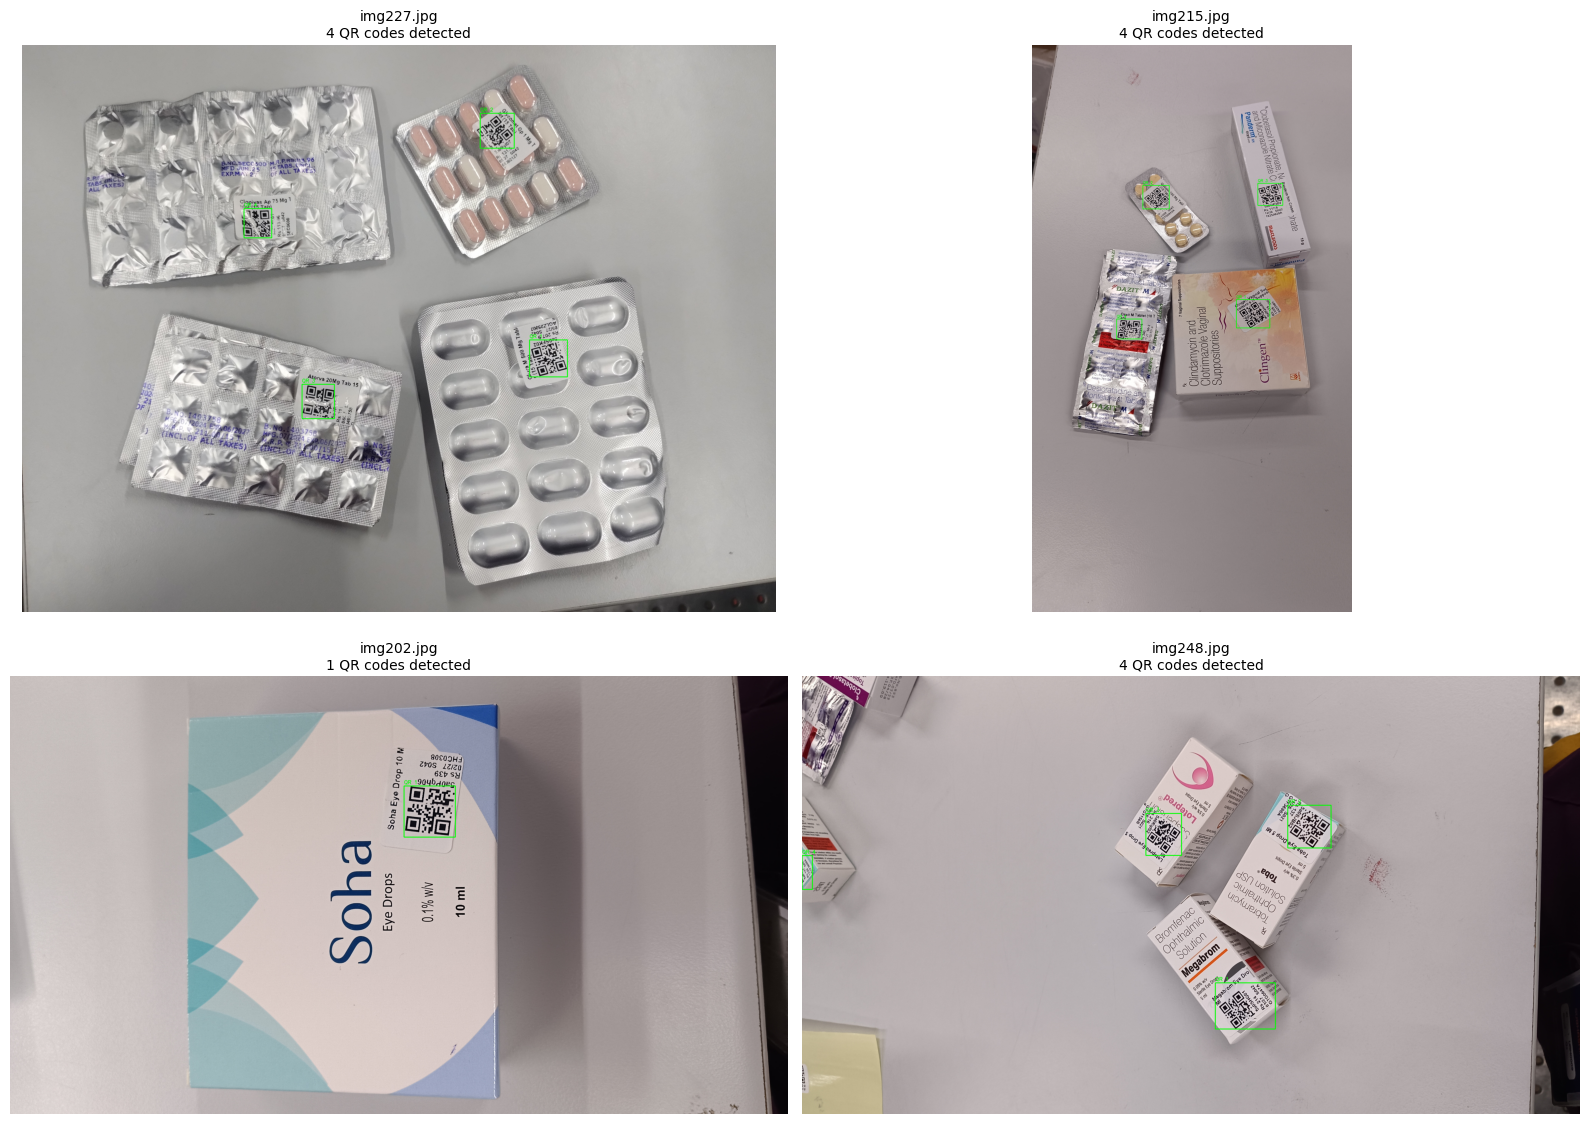


📊 Visualized 4 sample detections


In [53]:
# ================================================================
# CELL 16: Visualize Sample Results
# ================================================================

import matplotlib.pyplot as plt
import cv2
import random

# Select random test images to visualize
test_images_path = f"{DRIVE_DATA_PATH}/test/images"
image_files = [f for f in os.listdir(test_images_path)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Visualize 4 random images
num_samples = min(4, len(image_files))
sample_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, img_file in enumerate(sample_images):
    img_path = os.path.join(test_images_path, img_file)
    image_id = os.path.splitext(img_file)[0]

    # Find detection results
    result = next((r for r in results_stage1 if r['image_id'] == image_id), None)

    # Load and draw
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if result:
        for i, qr in enumerate(result['qrs']):
            bbox = qr['bbox']
            x_min, y_min, x_max, y_max = bbox

            # Draw rectangle
            cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

            # Add label
            label = f"QR {i+1}"
            cv2.putText(image_rgb, label, (x_min, y_min - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    axes[idx].imshow(image_rgb)
    axes[idx].set_title(f"{img_file}\n{len(result['qrs']) if result else 0} QR codes detected",
                        fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n📊 Visualized {num_samples} sample detections")

In [54]:
# ================================================================
# CELL 17: Download Results to Local Machine
# ================================================================

from google.colab import files

# Download submission files
print("Downloading submission files...")

try:
    files.download('outputs/submission_detection_1.json')
    print("✅ Downloaded: submission_detection_1.json")
except:
    print("⚠️  Could not download submission_detection_1.json")

try:
    files.download('outputs/submission_decoding_2.json')
    print("✅ Downloaded: submission_decoding_2.json")
except:
    print("⚠️  Could not download submission_decoding_2.json")

# Download trained model
try:
    files.download('outputs/qr_detection/weights/best.pt')
    print("✅ Downloaded: best.pt (trained model)")
except:
    print("⚠️  Could not download best.pt")

print("\n✅ All files ready for submission!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: submission_detection_1.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: submission_decoding_2.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: best.pt (trained model)

✅ All files ready for submission!


In [55]:
# ================================================================
# CELL 18: Summary Statistics
# ================================================================

print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

# Stage 1 stats
total_images_stage1 = len(results_stage1)
total_qr_stage1 = sum(len(r['qrs']) for r in results_stage1)
avg_qr_stage1 = total_qr_stage1 / total_images_stage1 if total_images_stage1 > 0 else 0

print(f"\n📊 Stage 1 (Detection):")
print(f"   Total images: {total_images_stage1}")
print(f"   Total QR codes detected: {total_qr_stage1}")
print(f"   Average QR per image: {avg_qr_stage1:.2f}")

# Stage 2 stats
total_decoded = sum(1 for r in results_stage2 for qr in r['qrs']
                    if qr.get('value') != 'DECODE_FAILED')
decode_rate = (total_decoded / total_qr_stage1 * 100) if total_qr_stage1 > 0 else 0

print(f"\n📊 Stage 2 (Decoding - Bonus):")
print(f"   Successfully decoded: {total_decoded}/{total_qr_stage1}")
print(f"   Decode success rate: {decode_rate:.1f}%")

# QR type distribution
from collections import Counter
qr_types = [qr['type'] for r in results_stage2 for qr in r['qrs']
            if qr.get('type') and qr.get('type') != 'unknown']
type_counts = Counter(qr_types)

if type_counts:
    print(f"\n📊 QR Code Types Detected:")
    for qr_type, count in type_counts.most_common():
        print(f"   {qr_type}: {count}")

print("\n" + "=" * 70)
print("✅ Hackathon submission ready!")
print("=" * 70)
print("\nSubmission files:")
print("  1. outputs/submission_detection_1.json (Stage 1 - Mandatory)")
print("  2. outputs/submission_decoding_2.json (Stage 2 - Bonus)")
print("  3. outputs/qr_detection/weights/best.pt (Trained model)")
print("\n🚀 Good luck with the hackathon!")
print("=" * 70)

FINAL SUMMARY

📊 Stage 1 (Detection):
   Total images: 50
   Total QR codes detected: 186
   Average QR per image: 3.72

📊 Stage 2 (Decoding - Bonus):
   Successfully decoded: 155/186
   Decode success rate: 83.3%

📊 QR Code Types Detected:
   general: 155

✅ Hackathon submission ready!

Submission files:
  1. outputs/submission_detection_1.json (Stage 1 - Mandatory)
  2. outputs/submission_decoding_2.json (Stage 2 - Bonus)
  3. outputs/qr_detection/weights/best.pt (Trained model)

🚀 Good luck with the hackathon!
